In [1]:
using Clapeyron
using Plots
using CSV
using DataFrames
using LaTeXStrings
using Measures

### Ternary MEA+H2O+CO2 Model

In [2]:
model_mix = SAFTgammaMie([("MEA",["NH2"=>1, "CH2"=>1, "CH2OH"=>1]),("Water",["H2O"=>1]),("Carbon Dioxide",["CO2"=>1])];

        userlocations = (Mw = [16.02285, 14.02658, 31.03392, 18.01528, 44.01],

        epsilon = [284.78 348.39 528.21 339.89 134.58;
                   348.39 473.39 423.17 423.63 276.45;
                   528.21 423.17 407.22 358.02 312.3;
                   339.89 423.63 358.02 266.68 226.38;
                   134.58 276.45 312.3 226.38 207.89],
        sigma = [3.2477, 4.8801, 3.4054, 3.0063, 3.05],
        lambda_a = [6, 6, 6, 6, 5.055],
        lambda_r = [10.354 14.063 52.305 13.085 50.06;
                    14.063 19.871 21.230 100.00 22.873;
                    52.305 21.230 22.699 19.619 24.474;
                    13.085 100.00 19.619 17.020 21.116;
                    50.06  22.873 24.474 21.116 26.408],
        vst = [1, 1, 2, 1, 2],
        S = [0.79675, 0.22932, 0.58538, 1, 0.84680],
        n_H=[2, 0, 1, 2, 0],
        n_e=[1, 0, 2, 2, 0],
        n_a1=[0, 0, 0, 0, 1],
       # n_a1e=[1, 0, 0, 1, 0],
        n_a2=[0, 0, 0, 0, 1],
        #n_a2e=[1, 0, 0, 0, 0],
        epsilon_assoc = Dict([(("NH2","H"),("NH2","e")) => 1070.80,
                              (("NH2","H"),("CH2OH","e")) => 629.88,
                              (("NH2","H"),("H2O","e")) => 1364.40,
                              (("CH2OH","H"),("NH2","e")) => 2403.78,
                              (("CH2OH","H"),("CH2OH","e")) => 2097.90,
                              (("CH2OH","H"),("H2O","e")) => 600.00,
                              (("H2O","H"),("NH2","e")) => 1877.50,
                              (("H2O","H"),("CH2OH","e")) => 2000.6,
                              (("H2O","H"),("H2O","e")) => 1985.40,
                              (("CO2","a1"),("NH2","e")) => 3313,
                              (("CO2","a1"),("H2O","e")) => 1398.1,
                              (("CO2","a2"),("NH2","e")) => 4943.6]),
                              #(("CO2","a1"),("NH2","a1e")) => 3313,
                
                              #(("CO2","a1"),("H2O","a1e")) => 1398.1,
                 
                              #(("CO2","a2"),("NH2","a2e")) => 4943.6]),

        bondvol = Dict([(("NH2","H"),("NH2","e")) => 95.225e-30,
                              (("NH2","H"),("CH2OH","e")) => 346.08e-30,
                              (("NH2","H"),("H2O","e")) => 22.450e-30,
                              (("CH2OH","H"),("NH2","e")) => 26.192e-30,
                              (("CH2OH","H"),("CH2OH","e")) => 62.309e-30,
                              (("CH2OH","H"),("H2O","e")) => 490.19e-30,
                              (("H2O","H"),("NH2","e")) => 459.18e-30,
                              (("H2O","H"),("CH2OH","e")) => 130.02e-30,
                              (("H2O","H"),("H2O","e")) => 101.69e-30,
                              (("CO2","a1"),("NH2","e")) => 3280.3e-30,
                              (("CO2","a1"),("H2O","e")) => 91.419e-30,
                              (("CO2","a2"),("NH2","e")) => 142.64e-30])));
                
                              #(("CO2","a1"),("NH2","a1e")) => 3280.3e-30,
                
                              #(("CO2","a1"),("H2O","a1e")) => 91.419e-30,
                 
                              #(("CO2","a2"),("NH2","a2e")) => 142.64e-30])));

### Calculate Water and MEA mole fractions at the set weight fractions


In [3]:
wt_MEA = 0.3
wt_H2O = 1-wt_MEA

mw_MEA = 61.08
mw_H2O = 18.01528

x_MEA = (wt_MEA/mw_MEA)*(1/((wt_MEA/mw_MEA)+(wt_H2O/mw_H2O)))
x_H2O = 1-x_MEA
solvrat = x_H2O/x_MEA

7.911062165006595

### Now create the loadings of CO2 and recalculate the mole fractions in the liquid phase

In [4]:
load = LinRange(0, 1.2, 100) #these are the ratio of CO2 mols to MEA mols in solution

N = length(load)

# intialise new composition vectors
x_MEA = zeros(N, 1)
x_H2O = zeros(N, 1)
x_CO2 = zeros(N, 1)
z = zeros(N, 3)

# calculate the new liquid compositions at these loadings
x_MEA = 1 ./ (1 .+ load .+ solvrat)
x_CO2 = x_MEA .* load
x_H2O = 1 .- x_MEA .- x_CO2
z = hcat(x_MEA, x_H2O, x_CO2);

### Can now calculate the expected vapour phase composition and pressure in equilibrium with this mixture

In [5]:
T = [298.15, 313.15, 333.15, 353.15, 373.15]

pvap = zeros(N, 5)
y = zeros(N, 3, 5)
partial = zeros(N, 5)

for j in 1:5
        
    for i in 1:N
        x_bub = z[i, :]
        calc = bubble_pressure(model_mix, T[j], x_bub)
        pvap[i, j] = calc[1]
        y[i, 1, j] = calc[4][1]
        y[i, 2, j] = calc[4][2]
        y[i, 3, j] = calc[4][3]
    end

end

partialT1 = pvap[2:100, 1] .* y[2:100, 3, 1]
partialT2 = pvap[2:100, 2] .* y[2:100, 3, 2]
partialT3 = pvap[2:100, 3] .* y[2:100, 3, 3]
partialT4 = pvap[2:100, 4] .* y[2:100, 3, 4]
partialT5 = pvap[2:100, 5] .* y[2:100, 3, 5]

#partial = pvap.*y[:,3]
#partialfil = partial[2:100]


loadfil = load[2:100];


### Import the relevant Values from Felipe's code

In [6]:
dataT2 = CSV.read("solubilityCO2_MEA_C1_T2.csv", DataFrame; header=false)
#dataT3 = CSV.read("solubilityCO2_MEA_C1_T2.csv", DataFrame; header=false)
#dataT4 = CSV.read("solubilityCO2_MEA_C1_T2.csv", DataFrame; header=false)

rename!(dataT2, ["Loading", "Pressure", "xH2O", "xMEA", "xCO2"]);

loadingexp = dataT2.Loading
pressureexp = dataT2.Pressure
yCO2exp = dataT2.xCO2
partialexp = pressureexp .* yCO2exp


partialexpfil = partialexp[2:100]
loadingexpfil = loadingexp[2:100];


### Plot the Results

In [7]:
exp_298 = CSV.read("MEA_H2O_CO2_loading_298.15.csv",
               header=[1, 2, 3],
               DataFrame);

exp_313 = CSV.read("MEA_H2O_CO2_loading_313.15.csv",
               header=[1, 2, 3],
               DataFrame);

exp_333 = CSV.read("MEA_H2O_CO2_loading_333.15.csv",
               header=[1, 2, 3],
               DataFrame);

exp_353 = CSV.read("MEA_H2O_CO2_loading_353.15.csv",
               header=[1, 2, 3],
               DataFrame);
    
exp_373 = CSV.read("MEA_H2O_CO2_loading_373.15.csv",
               header=[1, 2, 3],
               DataFrame);

In [ ]:
plt = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      xtickfont = font(12),
      ytickfont = font(12),
      yaxis = :log,
      xlims = (0, 1),
      legend =:topleft,
      left_margin = 4mm,
      right_margin = 4mm,
      xguidefontsize=16,
      yguidefontsize=16)

plot!(plt, loadfil, partialT5, 
      color = "indianred2", 
      line = (:path, 3), 
      label = nothing)#"373.15K")

plot!(plt, loadfil, partialT4, 
      color = "springgreen4", 
      line = (:path, 3), 
      label = nothing)#"353.15K")

plot!(plt, loadfil, partialT3, 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = nothing)#"333.15K")

plot!(plt, loadfil, partialT2, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = nothing)#"313.15K")

plot!(plt, loadfil, partialT1, 
      color = "chocolate1", 
      line = (:solid, 3), 
      label = nothing)#"298.15K")

#=
plot!(plt, loadingexpfil, partialexpfil, 
      seriestype = :path, 
      color = "Black", 
      markerstrokecolor = "white", 
      line = (:solid, 3), 
      label = "Perdomo et al. 298.15K")
=#


plot!(plt, exp_373[:, 2], exp_373[:, 1],
            seriestype = :scatter, 
            color = "white", 
            markerstrokecolor = "indianred2",
            marker = :utriangle,
            markerstrokewidth = 1,
            line = (:scatter, 3), 
            label = "373.15K")

plot!(plt, exp_353[:, 2], exp_353[:, 1],
            seriestype = :scatter, 
            color = "white", 
            markerstrokecolor = "springgreen4",
            marker = :square,
            markerstrokewidth = 1,
            line = (:scatter, 3), 
            label = "353.15K")
    
plot!(plt, exp_333[:, 2], exp_333[:, 1],
            seriestype = :scatter, 
            color = "white", 
            markerstrokecolor = "deepskyblue1",
            marker = :circle,
            markerstrokewidth = 1,
            line = (:scatter, 3), 
            label = "333.15K")

plot!(plt, exp_313[:, 2], exp_313[:, 1],
            seriestype = :scatter, 
            color = "white", 
            markerstrokecolor = "mediumorchid2",
            marker = :diamond,
            markerstrokewidth = 1,
            line = (:scatter, 3), 
            label = "313.15K")

plot!(plt, exp_298[:, 2], exp_298[:, 1],
            seriestype = :scatter, 
            color = "white", 
            markerstrokecolor = "chocolate1",
            marker = :hexagon,
            markerstrokewidth = 1,
            line = (:scatter, 3), 
            label = "298.15K")

xlabel!(plt, "θ"*L"\mathrm{_{CO_2}}")
ylabel!(plt, "P"*L"\mathrm{_{CO_2}}"*" / Pa")

#savefig(plt, "1_All_Temps_Loading_298")

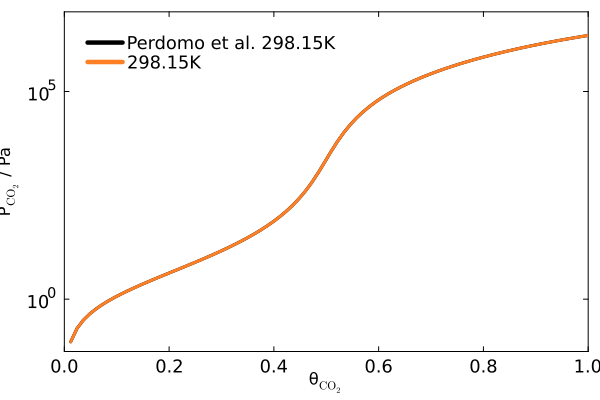

In [16]:
plt4 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      xtickfont = font(12),
      ytickfont = font(12),
      yaxis = :log,
      xlims = (0, 1),
      legend =:topleft)

     #= 
plot!(plt4, loadfil, partialT5, 
      color = "indianred2", 
      line = (:path, 3), 
      label = "373.15K")

plot!(plt, loadfil, partialT4, 
      color = "springgreen4", 
      line = (:path, 3), 
      label = "353.15K")

plot!(plt, loadfil, partialT3, 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = "333.15K")

plot!(plt, loadfil, partialT2, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = "313.15K")
=#

plot!(plt4, loadingexpfil, partialexpfil, 
      seriestype = :path, 
      color = "Black", 
      markerstrokecolor = "white", 
      line = (:solid, 3), 
      label = "Perdomo et al. 298.15K")
      
plot!(plt4, loadfil, partialT1, 
      color = "chocolate1", 
      line = (:solid, 3), 
      label = "298.15K")





xlabel!(plt4, "θ"*L"\mathrm{_{CO_2}}")
ylabel!(plt4, "P"*L"\mathrm{_{CO_2}}"*" / Pa")

#savefig(plt4, "1_Compara")

# check Felipe's other Values

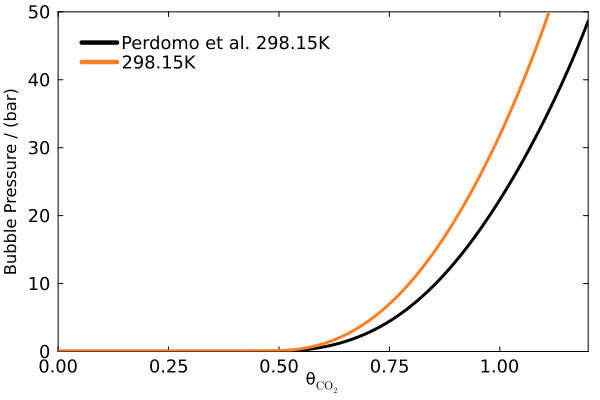

In [18]:
plt1 = plot(grid = :off, 
           framestyle = :box, 
           foreground_color_legend = nothing, 
           legend_font = font(12),
           xtickfont = font(12),
           ytickfont = font(12),
           xlims = (0, 1.2),
           ylims = (0, 5E06./1E05),
           legend =:topleft)

plot!(plt1, loadingexp, pressureexp./1E05, 
      color = "black", 
      line = (:solid, 3), 
      label = "Perdomo et al. 298.15K")

plot!(plt1, load, pvap[:, 2]./1E05, 
      color = "chocolate1", 
      line = (:path, 3), 
      label = "298.15K")


xlabel!(plt1, "θ"*L"\mathrm{_{CO_2}}")
ylabel!(plt1, "Bubble Pressure / (bar)")

#savefig(plt1, "1_Bubble_Pressure_298")


In [74]:
plt2 = plot(grid = :off, 
           framestyle = :box, 
           foreground_color_legend = nothing, 
           legend_font = font(12),
           xtickfont = font(12),
           ytickfont = font(12),
           xlims = (0, 1.2),
           ylims = (0, 1),
           legend =:topleft)

plot!(plt2, loadingexp, yCO2exp, 
      color = "black", 
      line = (:solid, 3), 
      label = "Perdomo et al. 298.15K")

plot!(plt2, load, y[:, 3, 2], 
      color = "chocolate1", 
      line = (:path, 3), 
      label = "298.15K")

xlabel!(plt2, "θ"*L"\mathrm{_{CO_2}}")
ylabel!(plt2, "y"*L"\mathrm{_{CO_2}}")

savefig(plt2, "1_Bubble_Comp_298")




"c:\\Users\\fjm21\\OneDrive - Imperial College London\\Julia Scripts\\Week 5\\1_Bubble_Comp_298.png"